## Libraries

In [1]:
import generate_dataset

In [4]:
#########################################################################################################
# An r-adaptive finite element method using neural networks for parametric self-adjoint elliptic problems
# Author: Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella,
#         David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte
#########################################################################################################

import jax.numpy as jnp
from jax import random, grad, jit
import jax
import jax.nn as nn
import numpy as np
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from fem_system import solve_and_loss, solve, solve_and_loss_scipy

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"
os.environ["KERAS_BACKEND"] = "jax"
import keras

# Set the random seed
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)
jax.config.update('jax_default_device', jax.devices('cpu')[0])


sys.path.append(os.path.abspath('..'))
key = jax.random.PRNGKey(0)

### Import dataset

In [5]:
dataset       = jnp.array(pd.read_csv('Dataset/dataset.csv').alpha)
train_indices = jnp.array(pd.read_csv('Dataset/train_indices.csv').train_indices)
test_indices  = jnp.array(pd.read_csv('Dataset/test_indices.csv').test_indices)

train_data   = dataset[train_indices]
test_data    = dataset[test_indices]
subset_test  = jnp.array(pd.read_csv('Dataset/test_subset.csv').test_subset)

### Ritz with uniform grid


In [6]:
def Exact_Ritz(alpha):
    alpha = jnp.asarray(alpha, dtype=jnp.float64)
    num     = (1.5 * alpha**2 - alpha)
    integral_term = num / (2 * alpha - 1)
    return integral_term - alpha

In [7]:
# Define the number of nodes
# Number of elements
N = 16
n_nodes       = N
uniform_grid  = jnp.linspace(0, 1, n_nodes + 1)

In [8]:
# Calcular el ritz con grilla uniforme para el set de entrenamiento
ritz_dict_train = {str(a): solve_and_loss(uniform_grid, a) for a in np.concatenate((train_data, subset_test))}

# Calcular el ritz con grilla uniforme para el set de validación
ritz_dict_test = {str(a): solve_and_loss(uniform_grid, a) for a in test_data}

### Neural Network

In [9]:
# Neural Network parameters

def init_params(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
        std_lecun = jnp.sqrt(1 / layers[i])
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1])) * std_lecun)
        bs.append(jnp.zeros(layers[i + 1]))
    return [Ws, bs]

@jit
def forward_pass(A_t, params):
    Ws, bs = params
    H = A_t
    for i in range(len(Ws) - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    theta = nn.softmax(jnp.matmul(H, Ws[-1]) + bs[-1], axis = -1)
    nodes = jnp.cumsum(theta, axis = -1)
    return jnp.insert(nodes, 0, 0, axis = -1)

def loss(params, alphas):
    losses = solve_and_loss_scipy(forward_pass(alphas, params), alphas.squeeze())
    return jnp.array([losses[i] / abs(ritz_dict_train[str(alpha)]) for i, alpha in enumerate(alphas.flatten())]).mean()

def loss_test(params, alphas, J_u):
    # Export history error
    J_u_theta = solve_and_loss_scipy(forward_pass(alphas, params), alphas.squeeze())
    return jnp.mean(jnp.sqrt(np.abs((J_u - J_u_theta)/J_u)))

def FEM_sol(params, alpha):
    nodes = forward_pass(alpha, params)
    return solve(nodes, jnp.squeeze(alpha))

def train(loss_fn, opt_state, alphas, test_subset, n_epochs=10, n_iter_per_epoch=1000, batch_size=1, lr=1e-2):
    train_loss = []
    test_loss  = []
    J_u        = jnp.array([Exact_Ritz(i) for i in test_subset]).squeeze()
    key = random.PRNGKey(100)
    n_alphas = alphas.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(lr)
    params   = get_params(opt_state)
    
    for epoch in range(n_epochs):
        key, subkey = random.split(key)
        idx = random.choice(subkey, n_alphas, (batch_size,), replace=False)
        sigma_batch = alphas[idx].reshape(-1, 1)

        for it in range(n_iter_per_epoch):
            params    = get_params(opt_state)
            grads     = grad(loss_fn)(params, sigma_batch)
            opt_state = opt_update(0, grads, opt_state)
        
        
        params = get_params(opt_state)
        loss_val = loss_fn(params, sigma_batch)
        train_loss.append(loss_val)
        test_loss.append(loss_test(params, test_subset, J_u))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss: {loss_val:.4e}, Test loss: {test_loss[-1]:.4e}, lr: {lr:.4e}")

    return get_params(opt_state), opt_state, train_loss, test_loss


### Training

In [10]:
# Network parameters and training configuration
iter       = 1  # Number of iterations per epoch
epochs     = 100
lr         = 1e-2
batch_size = 10

# Configuración de la red neuronal
layers = [1, 10, 10, n_nodes]
key    = random.PRNGKey(42)

# Configurar el optimizador Adam
opt_init, opt_update, get_params = optimizers.adam(lr)
params    = init_params(layers, key)
opt_state = opt_init(params)

# Entrenamiento
trained_param, opt_state_save, trained_error, test_loss = train(loss, opt_state, jnp.array(train_data), jnp.array([subset_test]).T, epochs, iter, batch_size, lr)


Epoch 0, Training loss: -1.0043e+00, Test loss: 1.4228e-01, lr: 1.0000e-02


Text(0.5, 1.0, 'Monitoring Error')

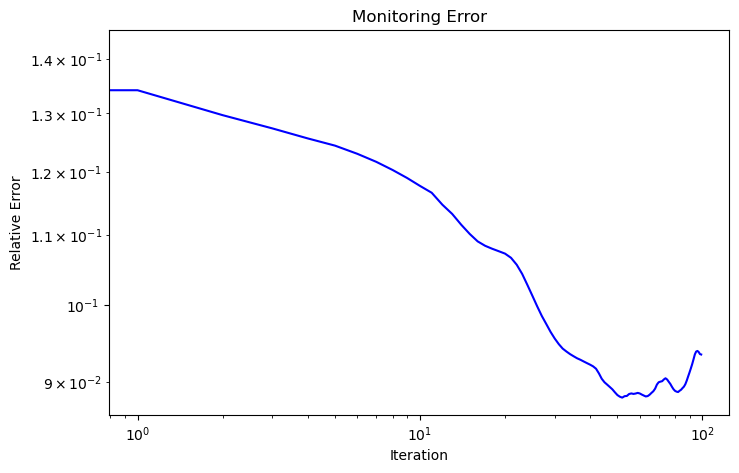

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.plot(test_loss, color='blue')
axs.set_xlabel('Iteration')
axs.set_ylabel('Relative Error')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_title('Monitoring Error')

### Test

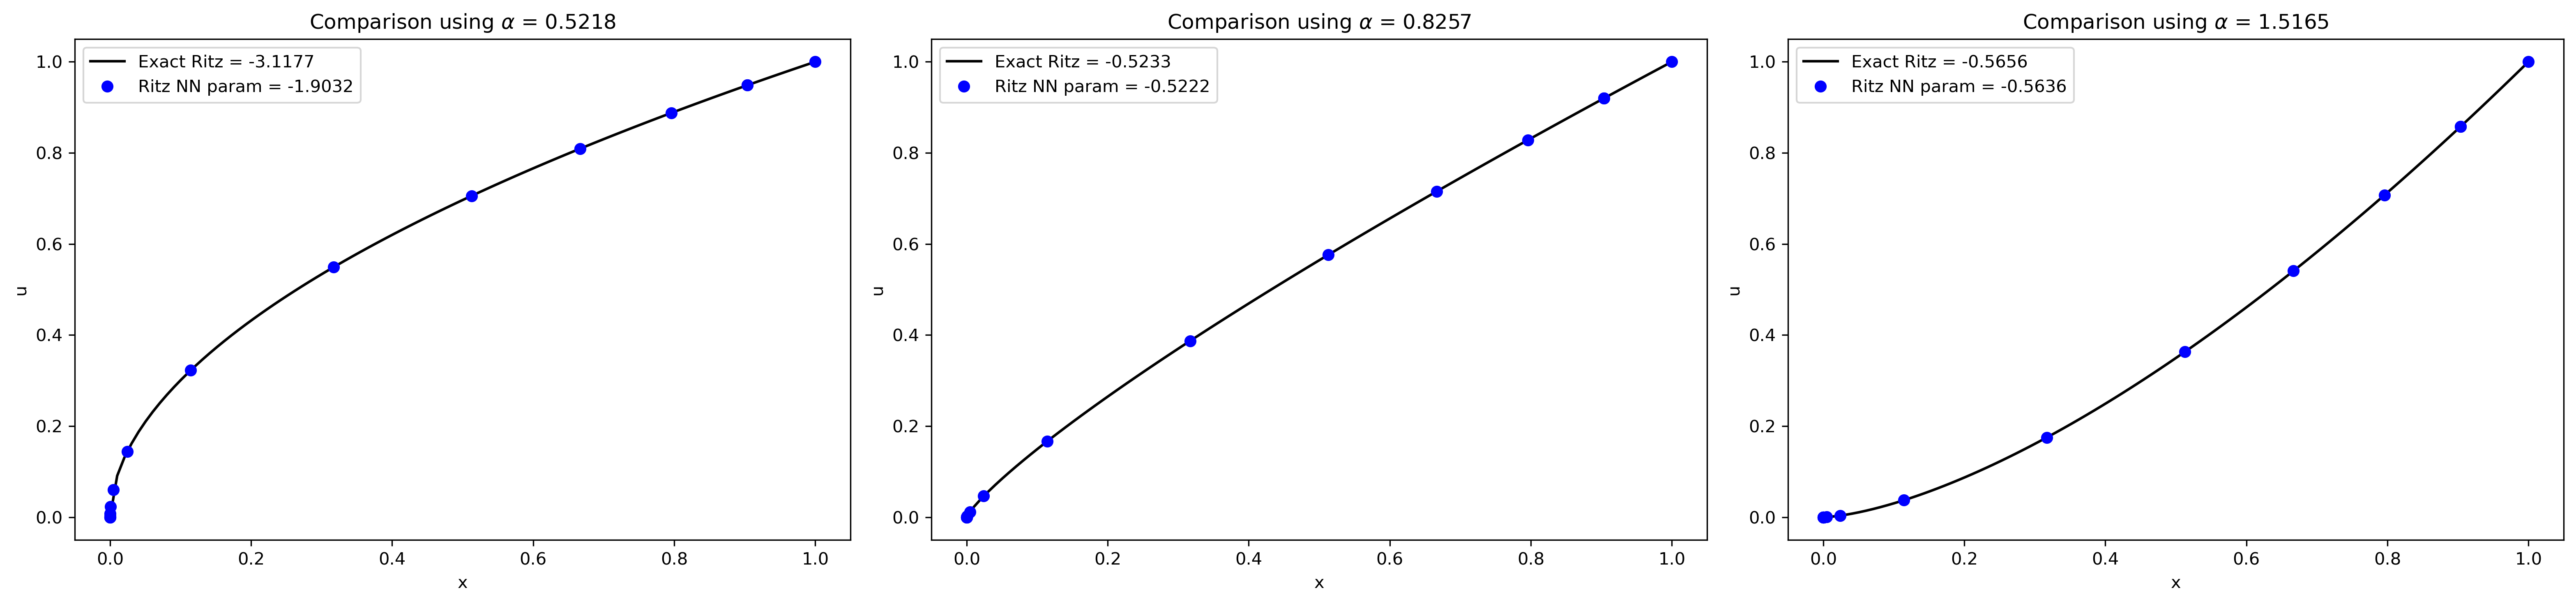

In [12]:
# Load data
special_test = np.array(pd.read_csv('Dataset/special_test.csv').values)

# Compare the results of using the initial neural network and the final neural network
x_exact = np.linspace(0, 1, 100)

fig, axs = plt.subplots(1, 3, figsize=(21, 5), dpi=300)


for i in range(len(special_test)):
    nodes_fullNN, u_fullNN = FEM_sol(trained_param, special_test[i])
    
    ritz_fullNN = solve_and_loss(forward_pass(special_test[i], trained_param), special_test[i][0])
    exact_ritz_val = Exact_Ritz(np.array(special_test[i][0]))
    u_exact = x_exact ** special_test[i]
    
    ax = axs[i]
    ax.plot(x_exact, u_exact, 'k', label=f'Exact Ritz = {Exact_Ritz(np.array(special_test[i][0])):.4f}')
    ax.plot(nodes_fullNN, u_fullNN, 'o', color='b')

    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend([f'Exact Ritz = {exact_ritz_val:.4f}', 
               f'Ritz NN param = {ritz_fullNN:.4f}',]) 
    ax.set_title(rf'Comparison using $\alpha$ = {special_test[i][0]:.4f}')
    
plt.tight_layout()
plt.show()

In [13]:
# Evaluate the NN in every test data and then compare the loss with the exact Ritz value

# List to save the Ritz values
ritz_test        = []
exact_ritz_test  = []
error_test       = []
rel_error_test   = []
rel_uniform_test = []

# Evaluate the NN in every test data
for i in range(len(test_data)):
    
    # Calculate the Ritz value
    ritz = solve_and_loss(forward_pass(np.array([test_data[i]]), trained_param), test_data[i])
    ritz_test.append(ritz)
    
    # Calculate the exact Ritz value
    exact_ritz = Exact_Ritz(np.array(test_data[i]))
    exact_ritz_test.append(exact_ritz)
    exact_ritz_bal = exact_ritz / ritz_dict_test[str(test_data[i])]

    # Calculate the error
    error = np.sqrt(abs((ritz - exact_ritz)/ritz_dict_test[str(test_data[i])]))
    error_test.append(error)

    # Calculate the relative error
    rel_error = error / np.sqrt(abs(exact_ritz_bal))
    rel_error_test.append(rel_error)
    
    # Calculate the relative error with the uniform grid
    rel_error_uni = np.sqrt(abs( (ritz_dict_test[str(test_data[i])] - exact_ritz) / exact_ritz ))
    rel_uniform_test.append(rel_error_uni)

# Evaluate the NN in every training data and then compare the loss with the exact Ritz value

# List to save the Ritz values
ritz_train          = []
exact_ritz_train    = []
error_train         = []
rel_error_train     = []
rel_uniform_train   = []

# Evaluate the NN in every training data
for i in range(len(train_data)):
    
    # Calculate the Ritz value
    ritz = solve_and_loss(forward_pass(np.array([train_data[i]]), trained_param), train_data[i])
    ritz_train.append(ritz)
    
    # Calculate the exact Ritz value
    exact_ritz = Exact_Ritz(np.array(train_data[i]))
    exact_ritz_train.append(exact_ritz)
    exact_ritz_bal = exact_ritz / ritz_dict_train[str(train_data[i])]

    # Calculate the error
    error = np.sqrt(abs((ritz - exact_ritz)/ritz_dict_train[str(train_data[i])]))
    error_train.append(error)

    # Calculate the relative error
    rel_error = error / np.sqrt(abs(exact_ritz_bal))
    rel_error_train.append(rel_error)

    # Calculate the relative error with the uniform grid
    rel_error_uni = np.sqrt(abs( (ritz_dict_train[str(train_data[i])] - exact_ritz) / exact_ritz ))
    rel_uniform_train.append(rel_error_uni)

In [14]:
# Compute statistics for the training set
train_mean_abs_error = np.mean(error_train)
train_mean_rel_error = np.mean(rel_error_train)
train_std_abs_error = np.std(error_train)
train_std_rel_error = np.std(rel_error_train)
train_max_abs_error = np.max(error_train)
train_max_rel_error = np.max(rel_error_train)
train_uniform_mean_rel_error = np.mean(rel_uniform_train) 
train_uniform_max_rel_error = np.max(rel_uniform_train)

# Compute statistics for the test set
val_mean_abs_error = np.mean(error_test)
val_mean_rel_error = np.mean(rel_error_test)
val_std_abs_error = np.std(error_test)
val_std_rel_error = np.std(rel_error_test)
val_max_abs_error = np.max(error_test)
val_max_rel_error = np.max(rel_error_test)
val_uniform_mean_rel_error = np.mean(rel_uniform_test)
val_uniform_max_rel_error = np.max(rel_uniform_test)

# Create a DataFrame to summarize the errors
data = {
    'Set': ['Train', 'Test'],
    'Mean Absolute Error': [train_mean_abs_error, val_mean_abs_error],
    'Mean Relative Error': [train_mean_rel_error, val_mean_rel_error],
    'Std Absolute Error': [train_std_abs_error, val_std_abs_error],
    'Std Relative Error': [train_std_rel_error, val_std_rel_error],
    'Max Absolute Error': [train_max_abs_error, val_max_abs_error],
    'Max Relative Error': [train_max_rel_error, val_max_rel_error],
    'Uniform grid Mean Relative error': [train_uniform_mean_rel_error, val_uniform_mean_rel_error],
    'Uniform grid Max Relative error': [train_uniform_max_rel_error, val_uniform_max_rel_error]
}

df_errors = pd.DataFrame(data)
df_errors

,Set,Mean Absolute Error,Mean Relative Error,Std Absolute Error,Std Relative Error,Max Absolute Error,Max Relative Error,Uniform grid Mean Relative error,Uniform grid Max Relative error
0,Train,0.132811,0.105773,0.250259,0.109868,2.253675,0.801613,0.122175,0.934603
1,Test,0.117318,0.098590,0.182733,0.100193,1.234058,0.624129,0.115174,0.862678
